I've taken help from <a href="https://towardsdatascience.com/building-neural-network-from-scratch-9c88535bf8e9"> blog on MLP </a>

In [ ]:
# importing libraries
import numpy as np
import typing as ty
import torchvision
import matplotlib.pyplot as plt
plt.style.use('dark_background')

# setting seed
np.random.seed(0)

def dataloader(flatten : bool = True):
    train_ = torchvision.datasets.MNIST("files/")

    train_dict = { i:[] for i in range(10) }

    for image, label in train_:
        train_dict[label].append(np.array(image)/255)

    # 1K images, 100 for each label
    train = []
    label = []
    for i in range(10):
        label.extend([i]*100)
        train.extend(train_dict[i][:100])
    y_train = np.array(label)
    X_train = np.array(train)

    # validation set
    train = []
    label = []
    for i in range(10):
        label.extend([i]*10)
        train.extend(train_dict[i][100:110])
    y_val = np.array(label)
    X_val = np.array(train)

    if flatten:
        X_train = X_train.reshape([X_train.shape[0], -1])
        X_val = X_val.reshape([X_val.shape[0], -1])
        X_test = X_val
        y_test = y_val
    return X_train, y_train, X_val, y_val, X_test, y_test

X_train, y_train, X_val, y_val, X_test, y_test = dataloader()

In [ ]:
plt.imshow(X_train[0].reshape(28,28), cmap = 'gray')
plt.title(f'label : {y_train[0]}')
plt.show()

In [145]:
# activation functions
def relu(x : ty.Union[float, np.ndarray]) -> ty.Union[float, np.ndarray]:
    """ReLU function
    
    returns max(0,x)"""
    return np.maximum(0,x)

def softmax(x : np.ndarray) -> np.ndarray:
    """Softmax function
    
    return [e^x_i/sum(e^x_i) for all i]"""
    denom = np.sum(np.exp(x))
    return np.exp(x)/denom

# max pooling
max_pool = lambda x: np.max(x)

In [146]:
class Layer:
    classmethod
    def __init__(self) -> None:
        pass

    @classmethod
    def forward(self, input : np.ndarray) -> np.ndarray:
        return input
    
    def backprop(self, input : np.ndarray, grad_in):
        pass

In [147]:
class ReLU(Layer):
    def __init__(self) -> None:
        pass

    def forward(self, input : np.ndarray):
        """forward pass relu function"""
        return relu(input)
    
    def backprop(self, input, grad_out):
        # ReLU gradient is 0 when input is negative, 1 otherwise
        return grad_out * (input > 0)

In [179]:
class Dense(Layer):
    def __init__(self, dimensions, learning_rate=0.1):
        """
        This function returns x.T W + b\\
        where W is the weight matrix,\\
        b is the bias vector\\
        These variables are defined for the class
        """
        self.learning_rate = learning_rate

        # *dimensions : * unpacks the tuple
        self.weights = np.random.randn(*dimensions)/np.sqrt(np.sum(dimensions)/2) #xavier initialization
        self.bias = np.zeros(dimensions[1])

    def forward(self,input):
        """
        This function returns XW + b\\
        where W is the weight matrix,\\
        b is the bias vector\\
        These variables are defined for the class
        """
        return np.dot(input, self.weights) + self.bias
    
    def backprop(self, input, grad_output):
        """
        We are given the gradient computed till this layer, we have
        to backpropagate it from this layer.\\
        This will be \\
        grad_out = dL/d(XW + b) \\
        further, \\
        dL/dx = dL/d(XW+b) d(XW+b)/dx \\
        dL/dx = grad_out * W.T
        """
        # gradient to be passed to previous layer
        grad_in = grad_output @ self.weights.T
        
        # compute gradient w.r.t. weights and bias
        # input.T       dim_in x N
        # grad_output   N x dim_out
        grad_weights = input.T @ grad_output
        # we are taking sum along the dimensions to bring down the dimensionality from 2D to a vector
        # essentially, we are adding the different gradients together.
        grad_bias = grad_output.sum(axis=0)
        
        # grad_weights is sum of gradients over the batch
        # so is grad_bias, it is also the sum of gradients over the batch.
        self.weights = self.weights - self.learning_rate * grad_weights
        self.biases = self.bias - self.learning_rate * grad_bias
        
        # returning the gradient for the previous layer
        return grad_in

In [180]:
def softmax_crossentropy_with_logits(logits, reference_answers):
    # Compute crossentropy from logits[batch,n_classes] and ids of correct answers
    logits_for_answers = logits[np.arange(len(logits)),reference_answers]
    
    xentropy = - logits_for_answers + np.log(np.sum(np.exp(logits),axis=-1))
    
    return xentropy
    
def grad_softmax_crossentropy_with_logits(logits,reference_answers):
    # Compute crossentropy gradient from logits[batch,n_classes] and ids of correct answers
    ones_for_answers = np.zeros_like(logits)
    ones_for_answers[np.arange(len(logits)),reference_answers] = 1
    
    softmax = np.exp(logits) / np.exp(logits).sum(axis=-1,keepdims=True)
    
    return (- ones_for_answers + softmax) / logits.shape[0]

In [181]:
network = []
network.append(Dense((X_train.shape[1],100)))
network.append(ReLU())
network.append(Dense((100,200)))
network.append(ReLU())
network.append(Dense((200,10)))

def forward(network, X):
    # Compute activations of all network layers by applying them sequentially.
    # Return a list of activations for each layer. 
    
    activations = []
    input = X
    # Looping through each layer
    for l in network:
        activations.append(l.forward(input))
        # Updating input to last layer output
        input = activations[-1]
    return activations
    
def predict(network,X):
    # Compute network predictions. Returning indices of largest Logit probability
    logits = forward(network,X)[-1]
    return logits.argmax(axis=-1)

def train(network,X,y):
    # Train our network on a given batch of X and y.
    # We first need to run forward to get all layer activations.
    # Then we can run layer.backward going from last to first layer.
    # After we have called backward for all layers, all Dense layers have already made one gradient step.
    
    
    # Get the layer activations
    layer_activations = forward(network, X)
    layer_inputs = [X]+layer_activations  #layer_input[i] is an input for network[i]
    logits = layer_activations[-1]
    
    # Compute the loss and the initial gradient
    loss = softmax_crossentropy_with_logits(logits,y)
    loss_grad = grad_softmax_crossentropy_with_logits(logits,y)
    
    # Propagate gradients through the network
    # Reverse propogation as this is backprop
    for layer_index in range(len(network))[::-1]:
        layer = network[layer_index]
        
        loss_grad = layer.backprop(layer_inputs[layer_index],loss_grad) #grad w.r.t. input, also weight updates
        
    return np.mean(loss)

Epoch 24
Train accuracy: 1.0
Val accuracy: 0.88


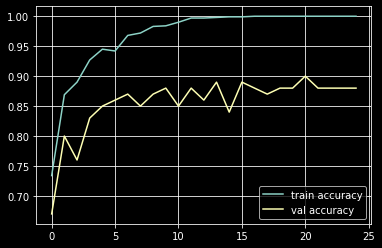

In [182]:
from tqdm import trange
def iterate_minibatches(inputs, targets, batchsize, shuffle=False):
    assert len(inputs) == len(targets)
    if shuffle:
        indices = np.random.permutation(len(inputs))
    for start_idx in trange(0, len(inputs) - batchsize + 1, batchsize):
        if shuffle:
            excerpt = indices[start_idx:start_idx + batchsize]
        else:
            excerpt = slice(start_idx, start_idx + batchsize)
        yield inputs[excerpt], targets[excerpt]
        
from IPython.display import clear_output
train_log = []
val_log = []
for epoch in range(25):
    for x_batch,y_batch in iterate_minibatches(X_train,y_train,batchsize=32,shuffle=True):
        train(network,x_batch,y_batch)
    
    train_log.append(np.mean(predict(network,X_train)==y_train))
    val_log.append(np.mean(predict(network,X_val)==y_val))
    
    clear_output()
    print("Epoch",epoch)
    print("Train accuracy:",train_log[-1])
    print("Val accuracy:",val_log[-1])
    plt.plot(train_log,label='train accuracy')
    plt.plot(val_log,label='val accuracy')
    plt.legend(loc='best')
    plt.grid()
    plt.show()